In [100]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import os
from sklearn import preprocessing
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [101]:
DB_Path = '/Users/dfreire/Dropbox/Datasets/small_dataset/train/'

In [276]:
def Load_Data_Fold(DB_path, k=2):
    #Numeric labels
    lab = preprocessing.LabelEncoder()
    lab.fit(os.listdir(DB_path))
    labels = lab.transform(os.listdir(DB_path))
    inv = lab.inverse_transform(labels)
    class_dict = dict(zip(inv, labels))

    #Read each folder
    data=[]
    labels=[]
    for class_ in os.listdir(DB_path):
        dat = [os.path.join(DB_path, classes_, img) for img in os.listdir(os.path.join(DB_path, class_))]
        lab = np.ones(len(dat))*class_dict[class_]
        
        labels = np.concatenate((labels,lab))
        data = data + dat
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(data, labels))
    
    return folds, data, labels

In [250]:
folds, data, labels = Load_Data_Fold(DB_path=DB_Path, k=1000)

In [251]:
len(folds)

1000

In [252]:
len(folds[0])

2

In [253]:
len(folds[0][0])

1998

In [254]:
len(folds[0][1])

2

In [255]:
2000/3

666.6666666666666

In [76]:
s = np.concatenate((a,b))

In [77]:
s

array([2., 2., 2., 2., 2., 3., 3., 3., 3., 3.])

In [ ]:
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = data[train_idx]
    y_train_cv = labels[train_idx]
    X_valid_cv = data[val_idx]
    y_valid_cv= labels[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))

In [30]:
# Enumerate labels

In [49]:
print(os.listdir(DB_Path))

['cats', 'dogs']


In [67]:
lab = preprocessing.LabelEncoder()
lab.fit(os.listdir(DB_Path))

LabelEncoder()

In [51]:
lab.classes_

array(['cats', 'dogs'], dtype='<U4')

In [52]:
labels = lab.transform(os.listdir(DB_Path))

In [53]:
print(labels)

[0 1]


In [62]:
inv = lab.inverse_transform(labels)
print(inv)

['cats' 'dogs']


In [65]:
class_dict = dict(zip(inv, labels))

In [277]:
# Our own generator

In [ ]:
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras."""
    def __init__(self, img_files, labels, ave=None, std=None, batch_size=32, dim=(300, 300), n_channels=3,
                 n_classes=2, shuffle=True):
        """Initialization.
        
        Args:
            img_files: A list of path to image files.
            labels: A list of corresponding labels.
        """
        self.img_files = img_files
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        if ave is None:
            self.ave = np.zeros(n_channels)
        else:
            self.ave = ave
        if std is None:
            self.std = np.zeros(n_channels) + 1
        else:
            self.std = std
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.floor(len(self.img_files) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        img_files_temp = [self.img_files[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(img_files_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.img_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_files_temp):
        """Generates data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # X = [np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))]
        X = []
        X_clinical = []
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, img_file in enumerate(img_files_temp):
            # Read image
            img = skimage.io.imread(img_file)
            
            # Resize
            img = skimage.transform.resize(img, output_shape=self.dim, mode='constant', preserve_range=True)
            
            # Normalization
            for ch in range(self.n_channels):
                img[:, :, ch] = (img[:, :, ch] - self.ave[ch])/self.std[ch]
            
            if self.shuffle:
                # Some image augmentation codes
                ###### You can put your preprocessing codes here. #####

            X.append(img)
            y[i] = self.labels[img_file]
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [1]:
from urllib.request import urlopen
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)

In [3]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
image = download_image('https://d177hi9zlsijyy.cloudfront.net/wp-content/uploads/sites/2/2018/05/11202041/180511105900-atlas-boston-dynamics-robot-running-super-tease.jpg')

In [104]:
import skimage.io
image = skimage.io.imread('/Users/dfreire/Dropbox/Web/yo1.jpg')

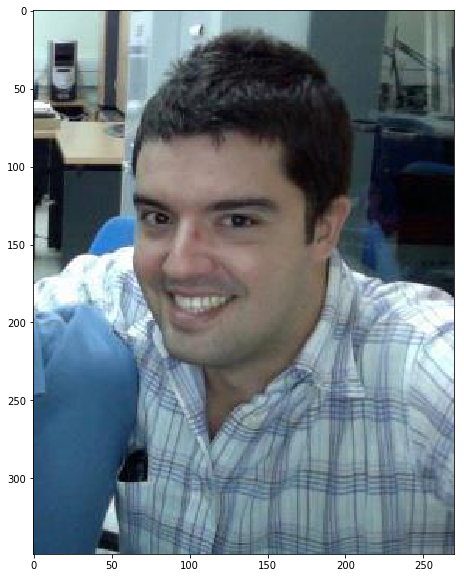

In [105]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [106]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

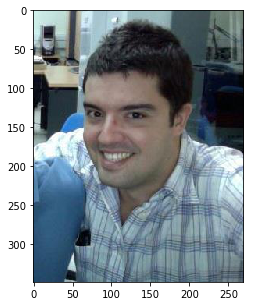

In [184]:
aug = HorizontalFlip(p=1)
#augment_and_show(aug, image)
image = aug(image=image)['image']
plt.figure(figsize=(5, 5))
plt.imshow(image)

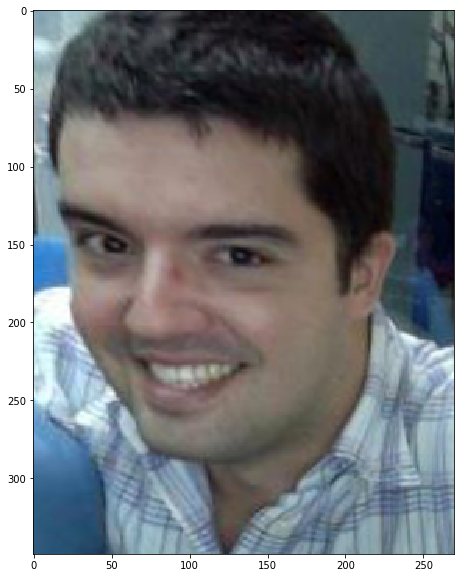

In [188]:
aug = IAAPerspective(scale=0.2, p=1)
augment_and_show(aug, image)

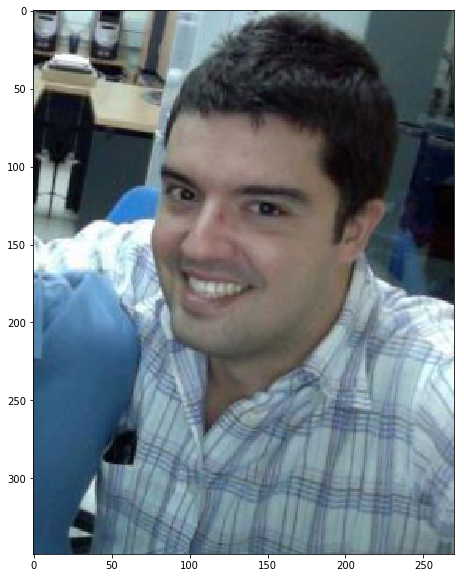

In [190]:
aug = ShiftScaleRotate(p=1)
augment_and_show(aug, image)

In [40]:
def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

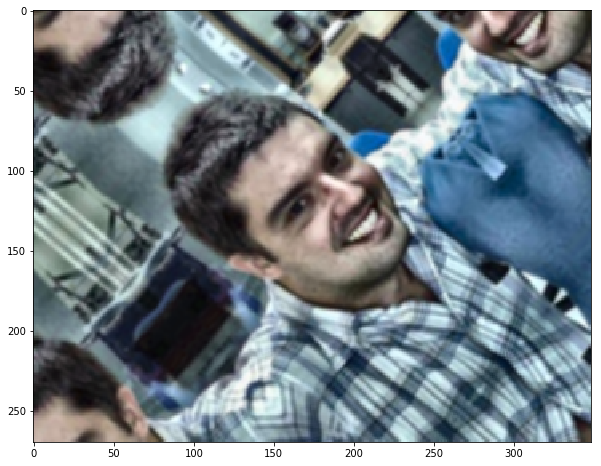

In [171]:
aug = augment_flips_color(p=1)
augment_and_show(aug, image)

In [49]:
def strong_aug(p=.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

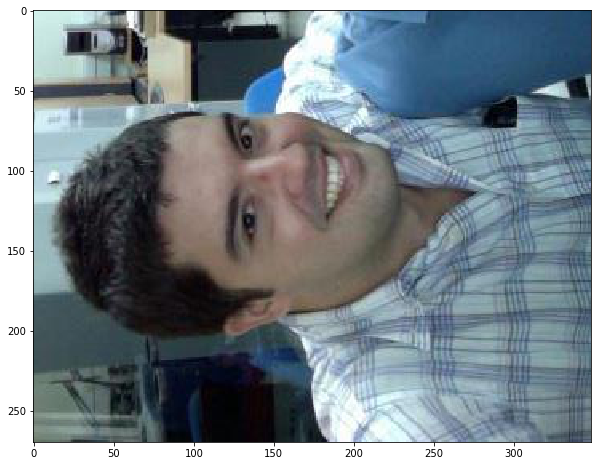

In [153]:
aug = strong_aug(p=1)
augment_and_show(aug, image)

In [193]:
from augmentations import augmentation_class